# Question 1 - Implement an anomalous detection system, using the ARIMA and the Artificial Neural Network (ANN) - LSTM (30 points).

### PART I - ARIMA (15 points)

The first part of the exercise is to implement a set of support ARIMA's functions. This functions is required to perform the main tasks related with ARIMA model.

In [142]:
from statsmodels.tsa.stattools import adfuller
import pyflux as pf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import pandas as pd

def load_arima_data(csv_file):
    ds = pd.read_csv(csv_file,
                         parse_dates=[0],infer_datetime_format=True)
    ds = ds.sort_index()
    print(ds.head())
    print(ds.tail())
    return ds

def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

    print('\n')


def plot_acf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data.dropna(), lags=40, ax=ax1)
    plt.title('Autocorrelation - Definition of p term - AR')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

def plot_pacf(data):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_pacf(data.dropna(), lags=40, ax=ax1)
    plt.title('Partial Autocorrelation - Definition of q term - MA')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

def split_arima_dataset(ds, target_field, test_size):
    ds  = ds.loc[:, [target_field]]

    train_set, test_set = train_test_split(ds, test_size=test_size, shuffle=False)
    test_set = test_set.sort_index()
    train_set = train_set.sort_index()
    return train_set, test_set

def generate_arima_model(dataset, diff, p, q, target_field):
    model = pf.ARIMA(data=dataset,
                     ar=p, ma=q, integ=diff, target=target_field,family=pf.Normal())
    return model

def fit_arima_model(model, algo):
    result = model.fit(algo, nsims=50000)
    print(result.summary())
    return model

def predict_arima (model, number_samples):
    pred_set = model.predict(h=number_samples)
    return pred_set


def plot_arima_result(y_test, predicted):
    try:
        plt.figure(figsize=(20, 8))

        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        #plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))


Following this, we load the dataset, to be analyzed.

In [143]:
csv_file = "Averaged_BearingTest_Dataset.csv"

data = load_arima_data(csv_file)

             datetime  Bearing1
0 2004-02-12 10:52:00  0.060236
1 2004-02-12 11:02:00  0.061455
2 2004-02-12 11:12:00  0.061361
3 2004-02-12 11:22:00  0.061665
4 2004-02-12 11:32:00  0.061944
               datetime  Bearing1
977 2004-02-19 05:42:00  0.453335
978 2004-02-19 05:52:00  0.337583
979 2004-02-19 06:02:00  0.351111
980 2004-02-19 06:12:00  0.001857
981 2004-02-19 06:22:00  0.001168


Once the dataset is loaded, we will check whether it is stationary or not, using the adfuller test. 

In [144]:
adfuller_test(data['Bearing1'])

ADF Test Statistic : 0.8917403093291825
p-value : 0.992981582856441
#Lags Used : 22
Number of Observations : 959
weak evidence against null hypothesis,indicating it is non-stationary 




As we can see, the dataset is not stationary. So, we will apply one differencing on that.

In [145]:
data['DiffBearing1'] = data['Bearing1'] - data['Bearing1'].shift(1)
adfuller_test(data['DiffBearing1'].dropna())
data.dropna(inplace=True)

ADF Test Statistic : -7.127045167564613
p-value : 3.5976701044451064e-10
#Lags Used : 22
Number of Observations : 958
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary




Now, the series is stationary.
The next step is to plot of autocorrelation to check the AR (p) term.

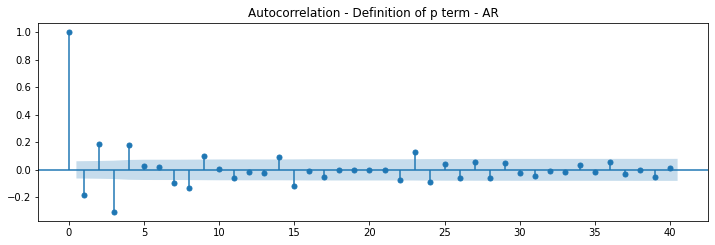

In [146]:
plot_acf(data['DiffBearing1'])

Check the result; we can see that we can set p as 2,4,9, etc.

Next, we will plot the partial autocorrelation of data, calculating the MA (q) term.

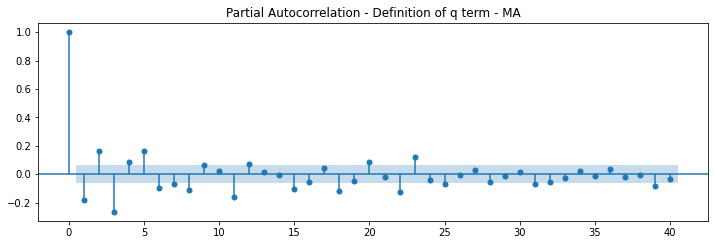

In [147]:
plot_pacf(data['DiffBearing1'])

Checking the result, we can set q as 2, 4, or 5, etc.

In [148]:
d = 1
p = 2
q = 2

The next phase is splitting the dataset into a training and a test dataset. We define that the training dataset size will have 80% of the original one.

In [149]:
arima_train_set, arima_test_set = split_arima_dataset(data, 'DiffBearing1', 0.2)

Now, we will generate the ARIMA model, using the training dataset previously created. 

In [150]:
model_arima = generate_arima_model(arima_train_set, d, p, q, "DiffBearing1")

If the model is created,  the next step is the model's fit, using the MLE algorithm. During this step, we will measure the time and cpu consume, aimiming provide insights to answer the question 2.

In [151]:
t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
model_arima = fit_arima_model(model_arima, "MLE")
t1=times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

Normal ARIMA(2,1,2)                                                                                       
======================================================= ==================================================
Dependent Variable: Differenced DiffBearing1            Method: MLE                                       
Start Date: 3                                           Log Likelihood: 3132.9802                         
End Date: 784                                           AIC: -6253.9603                                   
Number of observations: 781                             BIC: -6225.9969                                   
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Constant                                 0.0        0.0002     0.0302   0.9759   (-0.0005 | 0.0005)       
AR(1)                                

Analyzing the fit results, we can see that the values selected to MA and AR perform well.

The training time (arima_train_t) and the cpu consume (arima_cpu_train_perc) is calculated using following expressions:

In [152]:
arima_train_t = t1 - t0
arima_cpu_train = abs(cpu_t1 - cpu_t0)

Now, the model is ready to predict values. As we will use the testset to evaluate the model, we will generate the same number size of the testset to make predictions.

In [153]:
t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
arima_pred = predict_arima(model_arima, len(arima_test_set))
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

The prediction time (arima_pred_t) and the cpu consume (arima_cpu_pred_perc) is calculated using following expressions:

In [154]:
arima_pred_t = t1 - t0
arima_cpu_pred_perc = abs(cpu_t1 - cpu_t0)

Finally, we evaluate ARIMA, using the testset and predictions to perform this task.

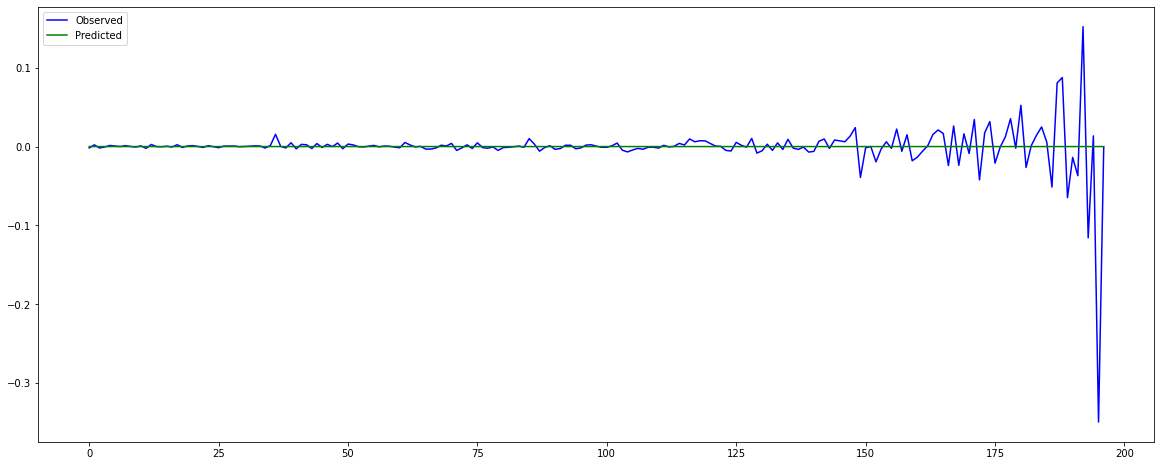

In [155]:
arima_pred = np.array(arima_pred.values)
arima_test_set = arima_test_set.values
X_test = arima_test_set[:, :-1]
arima_y_test = arima_test_set[:, -1]

plot_arima_result(arima_test_set, arima_pred)

### PART II - LSTM (15 POINTS)

The second part of the exercise is to implement a set of support LSTM's functions. This functions is required to perform the main tasks related with LSTM model.

In [156]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
import matplotlib.pyplot as plt

def load_lstm_data(csv_file,target_index,target_value):
    data_b = pd.read_csv(csv_file,   parse_dates=[target_index])
    data = data_b[target_value].values
    return data


def normalize_lstm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean


def prepare_lstm_data(data,test_size, sequence_length,is_normalized):
    print("Length of Data", len(data))

    train_start = 0
    train_end = (int)((len(data) * (1 - test_size)) - 1)
    test_start = 786  # train_end + 1
    test_end = 981  # len(data) - 1

    temp = []
    for index in range(train_start, train_end - sequence_length):
        temp.append(data[index: index + sequence_length])
    temp = np.array(temp)
    if is_normalized == True:
        temp, temp_mean = normalize_lstm(temp)

    train = temp[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]


    # test data
    print("Creating test data...")

    temp = []
    for index in range(test_start, test_end - sequence_length):
        temp.append(data[index: index + sequence_length])
    temp = np.array(temp)
    if is_normalized == True:
        temp, temp_mean = normalize_lstm(temp)

    X_test = temp[:, :-1]
    y_test = temp[:, -1]


    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test



def generate_lstm_model(sequence_length, loss, optimizer, metrics):
    model = Sequential()

    # First LSTM layer defining the input sequence length
    model.add(LSTM(input_shape=(sequence_length - 1, 1),
                   units=32,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Second LSTM layer with 128 units
    model.add(LSTM(units=128,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # Third LSTM layer with 100 units
    model.add(LSTM(units=100,
                   return_sequences=False))
    model.add(Dropout(0.2))

    # Densely-connected output layer with the linear activation function
    model.add(Dense(units=1))
    model.add(Activation('linear')) #sigmoid

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

def fit_lstm(model,X_train, y_train, batch_size, epochs, validation_split):
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    history = model.fit(
        X_train, y_train,verbose=1,
        batch_size=batch_size, epochs=epochs, validation_split=validation_split)
    return history

def predict_lstm(model, set_values_toPredict):
    predicted = model.predict(set_values_toPredict)
    print("Reshaping predicted")
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def plot_lstm_result(y_test, predicted):
    try:
        plt.figure(figsize=(20, 8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        #plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))

Following this, we define a set of variables, used during the LSTM creation and run, and load the dataset, to be analyzed.

In [157]:
sequence_length = 10
epochs = 30
batch_size = 100
validation_split = 0.05
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mean_squared_error']

data = load_lstm_data(csv_file, 0, "Bearing1")

The next step is cleaning the dataset, preparing it to be consumed by the LSTM engine. Perceive that we define does not normalize the dataset.

In [158]:
X_train, y_train, X_test, y_test = prepare_lstm_data(data, 0.2, sequence_length, False)

Length of Data 982
Creating test data...


Now, we are ready to generate the LSTM model.

In [159]:
lstm_model = generate_lstm_model(sequence_length, loss, optimizer, metrics)

As the model ready; following, we will fit the model, calculating the time and CPU consume to realize this task.

In [160]:
t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
history = fit_lstm(lstm_model, X_train, y_train, batch_size, epochs, validation_split)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

Epoch 1/30
8/8 [==============================] - 2s 195ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 8.8550e-05 - val_mean_squared_error: 8.8550e-05
Epoch 2/30
8/8 [==============================] - 0s 25ms/step - loss: 3.1528e-04 - mean_squared_error: 3.1528e-04 - val_loss: 1.4129e-04 - val_mean_squared_error: 1.4129e-04
Epoch 3/30
8/8 [==============================] - 0s 24ms/step - loss: 2.4483e-04 - mean_squared_error: 2.4483e-04 - val_loss: 6.5928e-05 - val_mean_squared_error: 6.5928e-05
Epoch 4/30
8/8 [==============================] - 0s 25ms/step - loss: 2.2778e-04 - mean_squared_error: 2.2778e-04 - val_loss: 7.8591e-05 - val_mean_squared_error: 7.8591e-05
Epoch 5/30
8/8 [==============================] - 0s 25ms/step - loss: 1.9340e-04 - mean_squared_error: 1.9340e-04 - val_loss: 7.3913e-05 - val_mean_squared_error: 7.3913e-05
Epoch 6/30
8/8 [==============================] - 0s 24ms/step - loss: 1.8852e-04 - mean_squared_error: 1.8852e-04 - val_loss: 6.740

To support the answer to question 2, we save the training (lstm_train_t) and CPU consumption (lstm_cpu_train_perc).

In [161]:
lstm_train_t = t1 - t0
lstm_cpu_train_perc = abs(cpu_t1 - cpu_t0)

Follow this; we will predict some samples to model's evaluation.

In [162]:
t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
lstm_pred = predict_lstm(lstm_model, X_test)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

Reshaping predicted


Finally, we calculate the CPU consume and time to predict phase and plot the result of predictions.

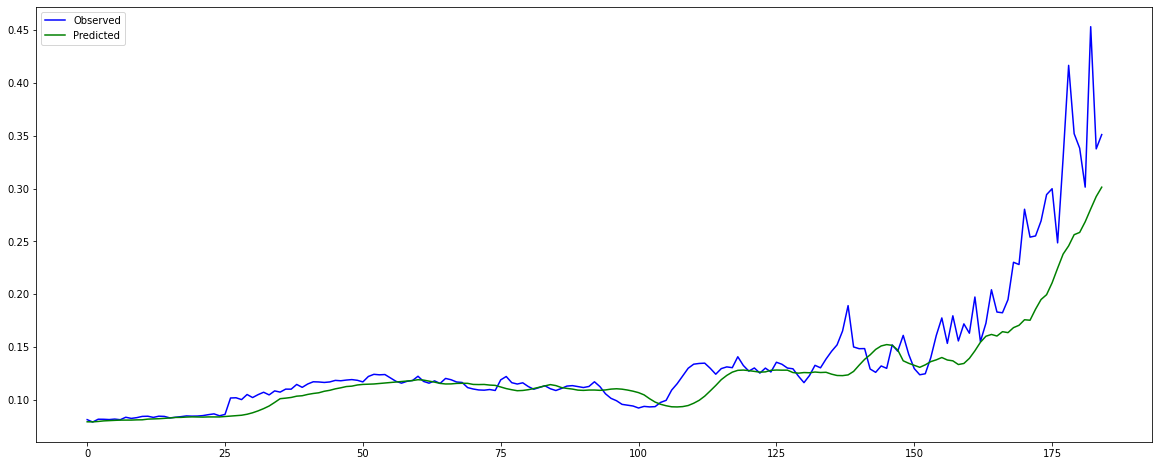

In [163]:
lstm_pred_t = t1 - t0
lstm_cpu_pred_perc = abs(cpu_t1 - cpu_t0)
plot_lstm_result(y_test, lstm_pred)

# Question 2 - Compare the performance (time and CPU consumption) during the training and the predictions performed by the two models (ARIMA and ANN) (30 points).

To compare the models performance, we will plot the CPU consumption and time using a bar chart.

In [164]:
def plot_bar(x,y, title):
    plt.bar(x, y, color=['firebrick', 'green', 'blue', 'black'])
    plt.xlabel('Categories')
    plt.ylabel("Values")
    plt.title(title)
    plt.show()

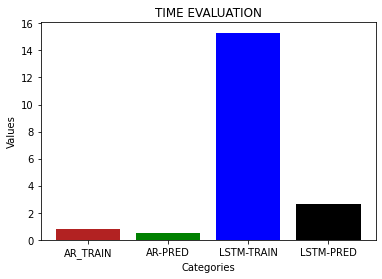

In [165]:
label = ["AR_TRAIN", "AR-PRED", "LSTM-TRAIN", "LSTM-PRED"]
time = [arima_train_t, arima_pred_t, lstm_train_t, lstm_pred_t]
plot_bar(label,time,"TIME EVALUATION")

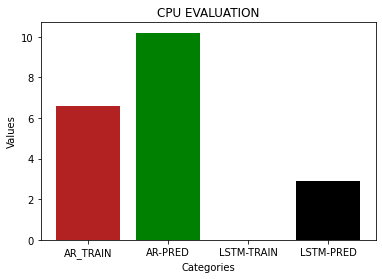

In [166]:
cpu = [ar_cpu_train_perc, arima_cpu_pred_perc, lstm_cpu_train_perc , lstm_cpu_pred_perc ]
plot_bar(label, cpu, "CPU EVALUATION")

# Question 3 - Measure and compare the accuracy (minimum loss error function) performed by both models (30 points).

To evaluate the error, we will use the Root Mean Squared Error (RMSE). In our case, we calculate the rmse to ARIMA and LSTM, and the best result is the smallest one.

source=https://www.relataly.com/measuring-prediction-errors-in-time-series-forecasting/809/

We define a new function to calculate the RMSE.

In [167]:
def rmse(true_v, pred):
    rmse = sqrt(mean_squared_error(true_v, pred))
    return rmse

ARIMA RMSE: 0.03192506540752011
LSTME RMSE:  0.030963274899332146


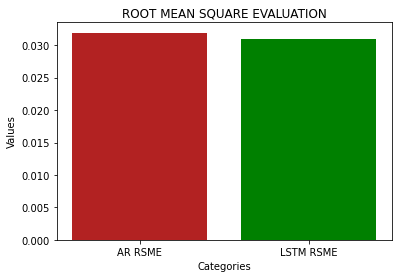

In [168]:
rmse_arima = rmse(arima_y_test, arima_pred)
print('ARIMA RMSE:',rmse_arima)

rmse_lstm = rmse(y_test, lstm_pred)
print('LSTME RMSE: ',rmse_lstm)

rmse_v=[rmse_arima,rmse_lstm]
label = ["AR RSME", "LSTM RSME"]
plot_bar(label,rmse_v, 'ROOT MEAN SQUARE EVALUATION')

Analyzing the previous chart, we can see that both models have a similar error. However, when you analyze the CPU consumption and time chart, we can conclude, despite the high time consumption of LSTM during training, in the general, it presents better cost-benefit results.  


**Observation: I suggest that you try to run the shared code using PyCharm editor. The performance using the IDE is completely different.



# Question 4 - Read the following paper and use one or more technics to decrease the neural network implementation error.  Submit the new code (separated from the previous one) and cite which technic(s) you used to improve the performance and what was more effective (10 points).

Following the reference link and the shared course support material, we define to change the normalization , the batch size, and number of epochs.
We will perform 4 experiences:

- experiment 1: normalization = false, epochs = 30, and batch_size = 100
- experiment 2: normalization = true, epochs = 30, and batch_size = 100
- experiment 3: normalization = false, epochs = 50, and batch_size = 100
- experiment 4: normalization = true, epochs = 50, and batch_size = 40

### Experiment 1

In [170]:
sequence_length = 10
epochs = 30
batch_size = 100
validation_split = 0.05
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mean_squared_error']

data = load_lstm_data(csv_file, 0, "Bearing1")
X_train, y_train, X_test, y_test = prepare_lstm_data(data, 0.2, sequence_length, False)
lstm_model = generate_lstm_model(sequence_length, loss, optimizer, metrics)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
history = fit_lstm(lstm_model, X_train, y_train, batch_size, epochs, validation_split)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp1_train_t = t1 - t0
exp1_cpu_train = abs(cpu_t1 - cpu_t0)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
lstm_pred = predict_lstm(lstm_model, X_test)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp1_pred_t = t1 - t0
exp1_cpu_pred = abs(cpu_t1 - cpu_t0)

exp1_rmse_lstm = rmse(y_test, lstm_pred)

Length of Data 982
Creating test data...
Epoch 1/30
8/8 [==============================] - 2s 198ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 1.8315e-04 - val_mean_squared_error: 1.8315e-04
Epoch 2/30
8/8 [==============================] - 0s 34ms/step - loss: 3.3023e-04 - mean_squared_error: 3.3023e-04 - val_loss: 1.7749e-04 - val_mean_squared_error: 1.7749e-04
Epoch 3/30
8/8 [==============================] - 0s 37ms/step - loss: 2.4972e-04 - mean_squared_error: 2.4972e-04 - val_loss: 1.7197e-04 - val_mean_squared_error: 1.7197e-04
Epoch 4/30
8/8 [==============================] - 0s 27ms/step - loss: 2.1079e-04 - mean_squared_error: 2.1079e-04 - val_loss: 1.6679e-04 - val_mean_squared_error: 1.6679e-04
Epoch 5/30
8/8 [==============================] - 0s 27ms/step - loss: 2.0748e-04 - mean_squared_error: 2.0748e-04 - val_loss: 1.6501e-04 - val_mean_squared_error: 1.6501e-04
Epoch 6/30
8/8 [==============================] - 0s 26ms/step - loss: 2.0049e-04 - mean_sq

### Experiment 2

In [171]:
sequence_length = 10
epochs = 30
batch_size = 100
validation_split = 0.05
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mean_squared_error']

data = load_lstm_data(csv_file, 0, "Bearing1")
X_train, y_train, X_test, y_test = prepare_lstm_data(data, 0.2, sequence_length, True)
lstm_model = generate_lstm_model(sequence_length, loss, optimizer, metrics)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
history = fit_lstm(lstm_model, X_train, y_train, batch_size, epochs, validation_split)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp2_train_t = t1 - t0
exp2_cpu_train = abs(cpu_t1 - cpu_t0)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
lstm_pred = predict_lstm(lstm_model, X_test)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp2_pred_t = t1 - t0
exp2_cpu_pred = abs(cpu_t1 - cpu_t0)

exp2_rmse_lstm = rmse(y_test, lstm_pred)

Length of Data 982
Creating test data...
Epoch 1/30
8/8 [==============================] - 2s 190ms/step - loss: 0.6637 - mean_squared_error: 0.6637 - val_loss: 0.1223 - val_mean_squared_error: 0.1223
Epoch 2/30
8/8 [==============================] - 0s 26ms/step - loss: 0.1657 - mean_squared_error: 0.1657 - val_loss: 0.0710 - val_mean_squared_error: 0.0710
Epoch 3/30
8/8 [==============================] - 0s 26ms/step - loss: 0.1342 - mean_squared_error: 0.1342 - val_loss: 0.0450 - val_mean_squared_error: 0.0450
Epoch 4/30
8/8 [==============================] - 0s 26ms/step - loss: 0.1011 - mean_squared_error: 0.1011 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 5/30
8/8 [==============================] - 0s 26ms/step - loss: 0.0902 - mean_squared_error: 0.0902 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 6/30
8/8 [==============================] - 0s 26ms/step - loss: 0.0859 - mean_squared_error: 0.0859 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoc

### Experiment 3

In [172]:
sequence_length = 10
epochs = 50
batch_size = 100
validation_split = 0.05
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mean_squared_error']

data = load_lstm_data(csv_file, 0, "Bearing1")
X_train, y_train, X_test, y_test = prepare_lstm_data(data, 0.2, sequence_length, False)
lstm_model = generate_lstm_model(sequence_length, loss, optimizer, metrics)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
history = fit_lstm(lstm_model, X_train, y_train, batch_size, epochs, validation_split)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp3_train_t = t1 - t0
exp3_cpu_train = abs(cpu_t1 - cpu_t0)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
lstm_pred = predict_lstm(lstm_model, X_test)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp3_pred_t = t1 - t0
exp3_cpu_pred = abs(cpu_t1 - cpu_t0)

exp3_rmse_lstm = rmse(y_test, lstm_pred)

Length of Data 982
Creating test data...
Epoch 1/50
8/8 [==============================] - 2s 205ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 3.6497e-04 - val_mean_squared_error: 3.6497e-04
Epoch 2/50
8/8 [==============================] - 0s 27ms/step - loss: 4.2118e-04 - mean_squared_error: 4.2118e-04 - val_loss: 2.9280e-04 - val_mean_squared_error: 2.9280e-04
Epoch 3/50
8/8 [==============================] - 0s 27ms/step - loss: 2.6428e-04 - mean_squared_error: 2.6428e-04 - val_loss: 3.0307e-04 - val_mean_squared_error: 3.0307e-04
Epoch 4/50
8/8 [==============================] - 0s 27ms/step - loss: 2.2466e-04 - mean_squared_error: 2.2466e-04 - val_loss: 3.3416e-04 - val_mean_squared_error: 3.3416e-04
Epoch 5/50
8/8 [==============================] - 0s 27ms/step - loss: 2.0366e-04 - mean_squared_error: 2.0366e-04 - val_loss: 2.8798e-04 - val_mean_squared_error: 2.8798e-04
Epoch 6/50
8/8 [==============================] - 0s 27ms/step - loss: 1.9459e-04 - mean_sq

8/8 [==============================] - 0s 28ms/step - loss: 1.9052e-05 - mean_squared_error: 1.9052e-05 - val_loss: 6.5792e-05 - val_mean_squared_error: 6.5792e-05
Epoch 48/50
8/8 [==============================] - 0s 34ms/step - loss: 1.9411e-05 - mean_squared_error: 1.9411e-05 - val_loss: 6.4074e-05 - val_mean_squared_error: 6.4074e-05
Epoch 49/50
8/8 [==============================] - 0s 32ms/step - loss: 2.1916e-05 - mean_squared_error: 2.1916e-05 - val_loss: 7.9440e-05 - val_mean_squared_error: 7.9440e-05
Epoch 50/50
8/8 [==============================] - 0s 31ms/step - loss: 1.9057e-05 - mean_squared_error: 1.9057e-05 - val_loss: 6.4390e-05 - val_mean_squared_error: 6.4390e-05
Reshaping predicted


### Experiment 4

In [173]:
sequence_length = 10
epochs = 50
batch_size = 40
validation_split = 0.05
loss = 'mean_squared_error'
optimizer = 'adam'
metrics = ['mean_squared_error']

data = load_lstm_data(csv_file, 0, "Bearing1")
X_train, y_train, X_test, y_test = prepare_lstm_data(data, 0.2, sequence_length, True)
lstm_model = generate_lstm_model(sequence_length, loss, optimizer, metrics)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
history = fit_lstm(lstm_model, X_train, y_train, batch_size, epochs, validation_split)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp4_train_t = t1 - t0
exp4_cpu_train = abs(cpu_t1 - cpu_t0)

t0 = times.time()
cpu_t0 = psutil.cpu_percent(interval=0.5)
lstm_pred = predict_lstm(lstm_model, X_test)
t1 = times.time()
cpu_t1 = psutil.cpu_percent(interval=0.5)

exp4_pred_t = t1 - t0
exp4_cpu_pred = abs(cpu_t1 - cpu_t0)

exp4_rmse_lstm = rmse(y_test, lstm_pred)

Length of Data 982
Creating test data...
Epoch 1/50
19/19 [==============================] - 2s 99ms/step - loss: 0.3671 - mean_squared_error: 0.3671 - val_loss: 0.2293 - val_mean_squared_error: 0.2293
Epoch 2/50
19/19 [==============================] - 1s 27ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.2089 - val_mean_squared_error: 0.2089
Epoch 3/50
19/19 [==============================] - 1s 27ms/step - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.1736 - val_mean_squared_error: 0.1736
Epoch 4/50
19/19 [==============================] - 0s 26ms/step - loss: 0.0728 - mean_squared_error: 0.0728 - val_loss: 0.1745 - val_mean_squared_error: 0.1745
Epoch 5/50
19/19 [==============================] - 1s 27ms/step - loss: 0.0686 - mean_squared_error: 0.0686 - val_loss: 0.1811 - val_mean_squared_error: 0.1811
Epoch 6/50
19/19 [==============================] - ETA: 0s - loss: 0.0760 - mean_squared_error: 0.07 - 1s 27ms/step - loss: 0.0746 - mean_squared_error: 

Now, we will evaluate the model.

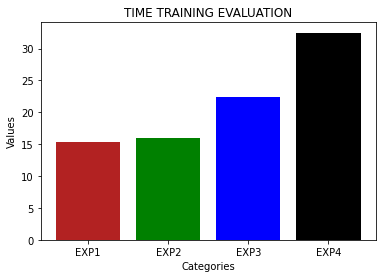

In [174]:
label = ["EXP1", "EXP2", "EXP3", "EXP4"]
time_train = [exp1_train_t, exp2_train_t,exp3_train_t,exp4_train_t]
plot_bar(label,time_train,"TIME TRAINING EVALUATION")

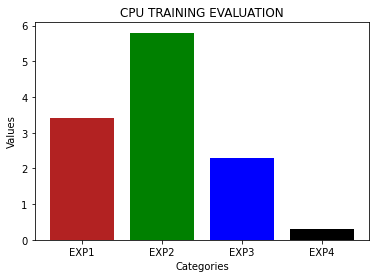

In [176]:
label = ["EXP1", "EXP2", "EXP3", "EXP4"]
CPU_train = [exp1_cpu_train, exp2_cpu_train,exp3_cpu_train,exp4_cpu_train]
plot_bar(label,CPU_train,"CPU TRAINING EVALUATION")

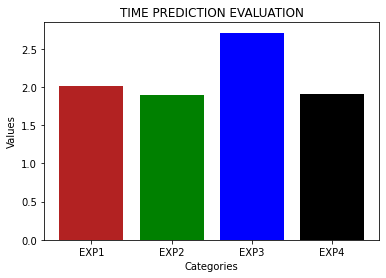

In [177]:
label = ["EXP1", "EXP2", "EXP3", "EXP4"]
time_pred = [exp1_pred_t, exp2_pred_t,exp3_pred_t,exp4_pred_t]
plot_bar(label,time_pred,"TIME PREDICTION EVALUATION")

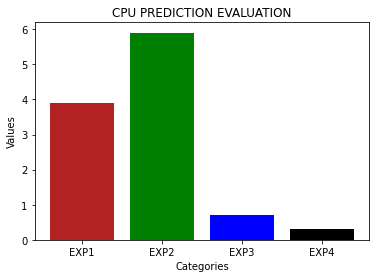

In [178]:
label = ["EXP1", "EXP2", "EXP3", "EXP4"]
CPU_pred = [exp1_cpu_pred, exp2_cpu_pred,exp3_cpu_pred,exp4_cpu_pred]
plot_bar(label,CPU_pred,"CPU PREDICTION EVALUATION")

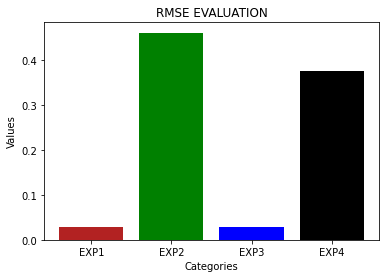

In [179]:
label = ["EXP1", "EXP2", "EXP3", "EXP4"]
rmse = [exp1_rmse_lstm, exp2_rmse_lstm,exp3_rmse_lstm,exp4_rmse_lstm]
plot_bar(label,rmse,"RMSE EVALUATION")

Analyzing the results, we can conclude that the configuration 1 (EXP1) and 3 (EXP3) provides the best model, as the RSME is minimum when you compare with the other configurations.

We can see that configuration 3 consumes more time than configuration 1; however, the difference is not so significant. Despite, when will be analyzed the CPU consumption, its results are much better than other approaches.